# Kalman Filter on Financial Time Series
We apply a simple Kalman Filter to denoise SPY log returns and estimate a latent state.

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pykalman import KalmanFilter

In [1]:
# Download SPY data
data = yf.download('SPY', start='2021-01-01', end='2023-01-01')

NameError: name 'yf' is not defined

In [4]:
data['LogReturn'] = np.log(data['Close']).diff()
log_returns = data['LogReturn'].dropna().values

In [5]:
# Apply Kalman Filter
kf = KalmanFilter(transition_matrices=[1],
                  observation_matrices=[1],
                  initial_state_mean=0,
                  initial_state_covariance=1,
                  observation_covariance=1,
                  transition_covariance=0.01)

state_means, _ = kf.filter(log_returns)

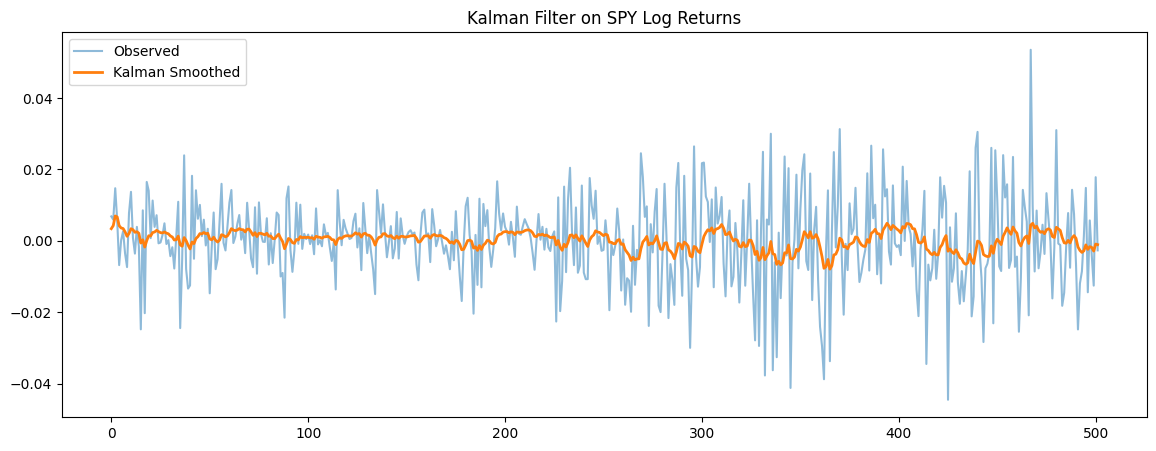

In [6]:
# Plot result
plt.figure(figsize=(14, 5))
plt.plot(log_returns, label='Observed', alpha=0.5)
plt.plot(state_means, label='Kalman Smoothed', linewidth=2)
plt.legend()
plt.title('Kalman Filter on SPY Log Returns')
plt.show()

Mean Squared Error: 0.000130
Mean Absolute Error: 0.008452


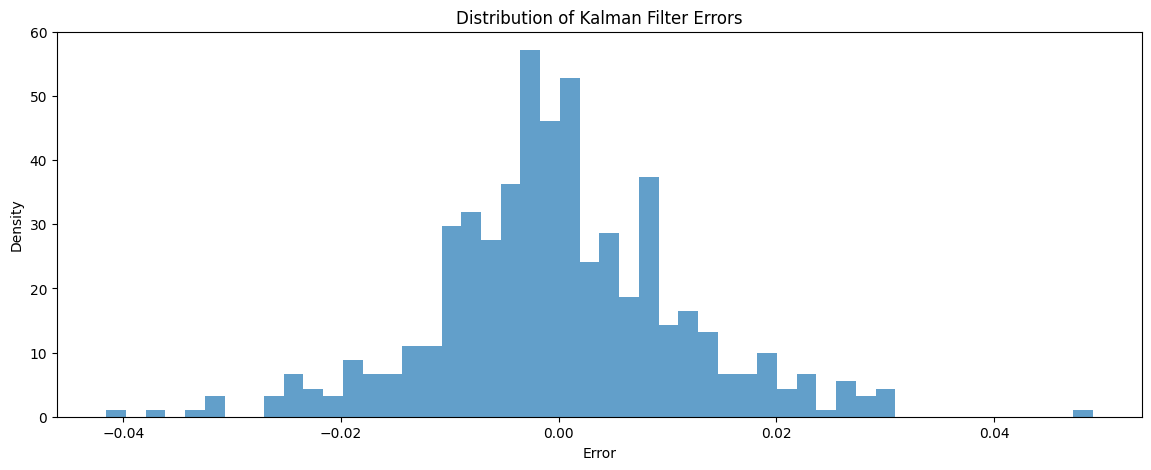

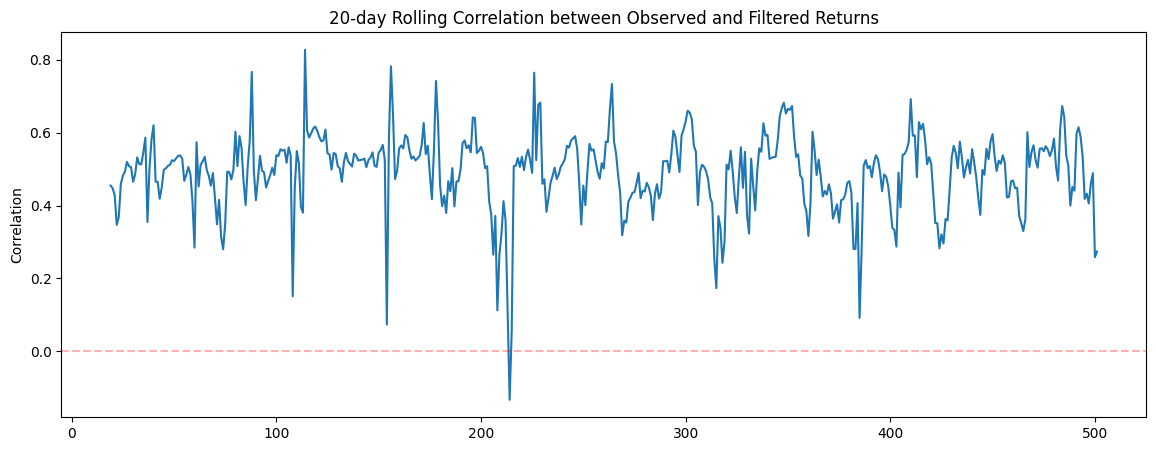


Summary Statistics:

Observed Returns:
count    502.000000
mean       0.000131
std        0.012269
min       -0.044456
25%       -0.006772
50%        0.000318
75%        0.007575
max        0.053497
dtype: float64

Filtered Returns:
count    502.000000
mean       0.000214
std        0.002498
min       -0.007894
25%       -0.001124
50%        0.000746
75%        0.001896
max        0.006985
dtype: float64


In [7]:
# Calculate performance metrics
mse = np.mean((log_returns - state_means.flatten())**2)
mae = np.mean(np.abs(log_returns - state_means.flatten()))
print(f"Mean Squared Error: {mse:.6f}")
print(f"Mean Absolute Error: {mae:.6f}")

# Plot the error distribution
plt.figure(figsize=(14, 5))
errors = log_returns - state_means.flatten()
plt.hist(errors, bins=50, density=True, alpha=0.7)
plt.title('Distribution of Kalman Filter Errors')
plt.xlabel('Error')
plt.ylabel('Density')
plt.show()

# Calculate rolling statistics
window = 20  # 20-day window
df = pd.DataFrame({
    'Observed': log_returns,
    'Filtered': state_means.flatten()
})
rolling_corr = df['Observed'].rolling(window).corr(df['Filtered'])

plt.figure(figsize=(14, 5))
plt.plot(rolling_corr)
plt.title(f'{window}-day Rolling Correlation between Observed and Filtered Returns')
plt.ylabel('Correlation')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.3)
plt.show()

# Print summary statistics
print("\nSummary Statistics:")
print("\nObserved Returns:")
print(pd.Series(log_returns).describe())
print("\nFiltered Returns:")
print(pd.Series(state_means.flatten()).describe())


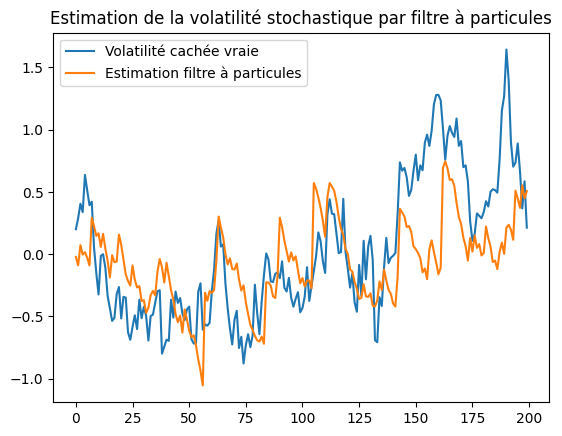

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation d'un modèle simple de volatilité stochastique
# Xt = log-return observé
# ht = volatilité cachée

def simulate_sv(T, mu=0, phi=0.95, sigma_h=0.2):
    h = np.zeros(T)
    x = np.zeros(T)
    h[0] = sigma_h
    for t in range(1, T):
        h[t] = phi * h[t-1] + sigma_h * np.random.randn()
        x[t] = mu + np.exp(h[t]/2) * np.random.randn()
    return x, h

# Filtre à particules
def particle_filter(y, N=1000, mu=0, phi=0.95, sigma_h=0.2):
    T = len(y)
    # Particules et poids
    particles = np.random.normal(0, sigma_h, size=N)  # init h0 particles
    weights = np.ones(N) / N

    h_estimates = np.zeros(T)

    for t in range(T):
        # Propagation des particules
        particles = phi * particles + sigma_h * np.random.randn(N)

        # Calcul des poids (vraisemblance)
        likelihoods = (1 / np.sqrt(2 * np.pi * np.exp(particles))) * \
                      np.exp(- (y[t] - mu)**2 / (2 * np.exp(particles)))
        weights *= likelihoods
        weights += 1e-300  # éviter zéro
        weights /= np.sum(weights)

        # Estimation
        h_estimates[t] = np.sum(particles * weights)

        # Resampling multinomial
        cumulative_sum = np.cumsum(weights)
        cumulative_sum[-1] = 1.  # éviter erreurs arrondi
        indexes = np.searchsorted(cumulative_sum, np.random.rand(N))

        particles = particles[indexes]
        weights.fill(1.0 / N)

    return h_estimates

if __name__ == "__main__":
    np.random.seed(42)                                
    = 200
    x, h_true = simulate_sv(T)

    h_est = particle_filter(x, N=1000)

    plt.plot(h_true, label="Volatilité cachée vraie")
    plt.plot(h_est, label="Estimation filtre à particules")
    plt.legend()
    plt.title("Estimation de la volatilité stochastique par filtre à particules")
    plt.show()
